# Parameter Sweeps with Provenance Tracking (Predator–Prey)

> **Prerequisites**
>
> This notebook assumes you've read the [Usage Guide](../docs/usage-guide.md).


## Notebook Goals

By the end of this notebook, you'll understand how to:
- Track provenance automatically for parameter sweeps without manual bookkeeping
- Use Consist's `scenario` and `step` abstractions to organize multi-run workflows
- Separate cache identity (`config`) from queryable metadata (`facet`)
- Query results across hundreds of runs using typed SQL views—no raw SQL strings
- Inspect the provenance database to understand what Consist stores


## Why Provenance Tracking for Parameter Sweeps?

When running Monte Carlo simulations or parameter sweeps, researchers often face questions like:
- "Which parameter settings produced that interesting result I saw last week?"
- "Did I already run this configuration, or do I need to re-run it?"
- "How do I compare results across different parameter regimes without manual bookkeeping?"

This notebook shows how Consist answers these questions automatically by treating provenance as a first-class concern. Every simulation run is recorded with its full configuration, and results can be queried across the entire sweep using typed SQL views—without writing any raw SQL or manually tracking file paths.

## Outline

This notebook is a walkthrough of Consist in a scientific simulation workflow:

1. Run a single simulation to preview the time series
2. Define a sweep (parameters + seeds)
3. Run one simulation per Consist step (each sweep member has provenance)
4. Export a SQLModel stub for the series artifact
5. Aggregate per-sim outputs with typed queries (no raw SQL)
6. Visualize summary metrics
7. Inspect what landed in the DuckDB file


## 0) Setup

This notebook writes outputs and DuckDB databases under `examples/runs/`.

We initialize a `Tracker` instance, which is the central object in Consist. It manages:
- **Run directory**: Where artifact files are stored on disk, organized by run
- **Database**: A DuckDB file that indexes runs, artifacts, and enables cross-run queries
- **Mounts**: Path mappings that make provenance portable across machines

Each notebook session gets a unique database file (via `SESSION_ID`) so you can re-run the notebook multiple times without conflicts or stale cache hits from previous sessions. In production workflows, you'd typically use a persistent database path.

> **Note**: The imports from `examples/src/pipeline_steps.py` and `examples/src/synth_simulation.py` contain the actual simulation logic. We've factored these out to keep the notebook focused on Consist's provenance features rather than model implementation details.



In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import consist


def _find_repo_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / "pyproject.toml").exists():
            return candidate
    raise RuntimeError("Could not locate repo root (missing pyproject.toml)")


REPO_ROOT = _find_repo_root(Path.cwd())
EXAMPLES_DIR = REPO_ROOT / "examples"
EXAMPLES_SRC = EXAMPLES_DIR / "src"

for path in (REPO_ROOT, EXAMPLES_SRC):
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))

In [2]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
from rich.progress import track

from consist import Tracker, pivot_facets, run_query, define_step

from pipeline_steps import (
    build_sweep_registry,
    make_run_id,
    run_one_simulation,
)
from synth_simulation import PredatorPreyConfig

sns.set_theme(style="whitegrid")
%config InlineBackend.figure_format = 'svg'

RUN_DIR = EXAMPLES_DIR / "runs" / "predator_prey_demo"
SESSION_ID = os.getenv("CONSIST_SESSION_ID", "demo")
DB_PATH = RUN_DIR / f"predator_prey_demo_{SESSION_ID}.duckdb"
if DB_PATH.exists():
    DB_PATH.unlink()

tracker = Tracker(run_dir=RUN_DIR, db_path=DB_PATH)

## Workflow Functions and Instrumentation Choices

This sweep uses two core functions and shows both `run(...)` and `trace(...)`.
For the distinction, see [sc.run vs sc.trace](../docs/usage-guide.md#when-does-code-execute-understanding-scrun-vs-sctrace).


## 1) Single Simulation Preview

Before running a full parameter sweep, it's useful to verify the model behaves as expected with a single configuration. This also helps us choose appropriate parameter ranges for the sweep.

The Lotka-Volterra predator-prey model exhibits characteristic oscillatory dynamics: prey populations grow, predators feast and multiply, prey decline, predators starve—and the cycle repeats. With stochastic dynamics (as implemented here), populations can also go extinct, which is one of the phenomena we'll explore in the sweep.

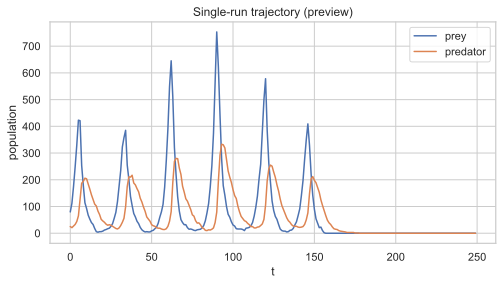

In [3]:
base_config = PredatorPreyConfig(
    steps=250,
    sample_every=1,
    prey_init=80,
    predator_init=25,
    predator_birth_efficiency=0.20,
)

preview_row = {
    "seed": 7,
    "prey_birth_rate": 0.70,
    "predation_rate": 0.011,
    "predator_birth_efficiency": 0.20,
    "predator_death_rate": 0.18,
}

preview_series = run_one_simulation(
    base_config=base_config,
    registry_row=preview_row,
)
display(preview_series.head(3))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(preview_series["t"], preview_series["prey"], label="prey")
ax.plot(preview_series["t"], preview_series["predator"], label="predator")
ax.set_title("Single-run trajectory (preview)")
ax.set_xlabel("t")
ax.set_ylabel("population")
ax.legend()
plt.show()

## 2) Define the Sweep

We construct a **registry**—a DataFrame where each row represents one simulation to run. The registry includes:
- **Parameter combinations**: Different values of prey birth rate, predation rate, etc.
- **Replicates**: Multiple runs per parameter setting (with different random seeds) to capture stochastic variation
- **Identifiers**: Unique IDs that we'll use as Consist run IDs

### Why a Registry?

This pattern separates "what to run" from "how to run it," which provides several benefits:
- **Resumability**: If the sweep crashes partway through, you can filter to incomplete rows and continue
- **Reproducibility**: The registry itself can be versioned and shared
- **Flexibility**: Easy to add/remove parameter combinations or increase replicates

The registry contains two ID columns:
- `sim_id`: Unique identifier for each simulation (one per row)
- `setting_id`: Shared across replicates of the same parameter combination—useful for grouping in analysis

In [4]:
registry = build_sweep_registry(
    # Tuned grid to highlight a transition region (coexistence ↔ extinction).
    # (The stochastic dynamics can be sensitive; this set usually shows mixed regimes.)
    prey_birth_rates=[0.60, 0.7, 0.75],
    predation_rates=[0.008, 0.011, 0.014],
    predator_death_rates=[0.15],
    predator_birth_efficiency=0.20,
    replicates_per_setting=10,
    seed=7,
)
print(f"sims={len(registry)} settings={registry['setting_id'].nunique()}")
registry.head()

,sim_id,setting_id,replicate_id,prey_birth_rate,predation_rate,predator_death_rate,predator_birth_efficiency,seed
0,0,0,0,0.6,0.008,0.15,0.2,2029167940
1,1,0,1,0.6,0.008,0.15,0.2,1342382291
2,2,0,2,0.6,0.008,0.15,0.2,1469265225
3,3,0,3,0.6,0.008,0.15,0.2,1926751965
4,4,0,4,0.6,0.008,0.15,0.2,1241873584


## 3) Running the Sweep with Provenance Tracking

This is where Consist shines. Each simulation becomes a **step** within a parent **scenario**, and Consist automatically:

1. **Records configuration**: The full parameter set is stored as both a cache key and queryable metadata
2. **Tracks artifacts**: Output files are logged with content hashes, enabling cache validation and lineage queries
3. **Enables caching**: If you re-run this cell, Consist will detect matching signatures and skip redundant computation

### Key Concepts

**Scenarios and Steps**

A `scenario` groups related runs under a common parent. Think of it as a "study" or "experiment." Each `step` within a scenario is an individual run with its own:
- Configuration (which drives caching)
- Artifacts (inputs and outputs)
- Metadata (tags, facets, timestamps)

This hierarchy lets you ask questions like "show me all runs from the baseline scenario" or "compare results across scenarios."

**`config=` vs `facet=`: Cache Identity vs Queryability**

This distinction is crucial:

| Parameter | Purpose                                                                                                                                                       | Effect                                                         |
|-----------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------|
| `config=` | **Cache identity**. A hash of this dictionary (combined with code version and input hashes) determines whether Consist reuses a cached result or re-executes. | Changing any value invalidates the cache for this run.         |
| `facet=`  | **Queryable metadata**. Stored in DuckDB with indexed keys for efficient filtering. Does *not* affect cache identity.                                         | You can filter runs by facet values without loading artifacts. |

Why separate them? Sometimes you want to store metadata that shouldn't affect caching (e.g., human-readable labels, denormalized fields for query convenience). The facet gives you a queryable "index" over your runs.

When facets are a subset of the config, use `facet_from=[...]` to extract keys directly from `config` and avoid duplication.

**Logging DataFrames**

`consist.log_dataframe(...)` does several things:
1. Writes the dataframe to disk (default Parquet)
2. Computes a content hash of the file (for cache validation and deduplication)
3. Records the file's path as a portable URI (relative to configured mounts)
4. Links the artifact to the current run with direction metadata (`input` or `output`)
5. Optionally stores additional metadata

The returned `Artifact` object wraps the path with provenance information—you can pass it to downstream tasks, and Consist will record the lineage.

## Optional: No Decorators

`@define_step(...)` is optional. You can also run inline callables and list outputs
directly on `run(...)`. That keeps things beginner-friendly while still recording artifacts.

```python
def simulate_once(*, base_config, sim_cfg):
    return run_one_simulation(base_config=base_config, registry_row=sim_cfg)

from consist import ExecutionOptions

scenario.run(
    name="sim_0001",
    fn=simulate_once,
    config={**asdict(base_config), **sim_cfg},
    outputs=["sim_series"],
    execution_options=ExecutionOptions(
        runtime_kwargs={"base_config": base_config, "sim_cfg": sim_cfg},
    ),
)
```


### Two execution patterns

In this notebook we show both styles:

- **`run(...)` with a reusable step function** (great when you want shared metadata or
  a named function for reuse).
- **`trace(...)` with inline code** (no wrapper needed; useful for one-off steps).

If you already have a library function that *logs outputs itself* using Consist
(e.g., it calls `consist.log_dataframe` internally), you can pass that function
directly to `run(...)` without a wrapper.


### Optional: Typed coupler view (encouraged)

Typed couplers are opt-in. They provide IDE autocomplete for coupler keys and clearer runtime errors when a declared output is missing. They do **not** change execution behavior or caching.

```python
from consist import coupler_schema
from consist.models.artifact import Artifact

@coupler_schema
class SweepCoupler:
    sim_series: Artifact

with consist.scenario("predator_prey_sweep") as scenario:
    scenario.declare_outputs("sim_series", required=True)
    typed = scenario.coupler_schema(SweepCoupler)
    # ... after steps run and outputs are logged
    _ = typed.sim_series
```


In [5]:
from dataclasses import asdict
from consist import ExecutionOptions


@define_step(outputs=["sim_series"], tags=["sim"])
def simulate_run(*, base_config, sim_cfg):
    series_df = run_one_simulation(
        base_config=base_config,
        registry_row=sim_cfg,
    )
    return series_df


scenario_id = "predator_prey_sweep"

sample_series_artifact = None

with consist.scenario(
    scenario_id,
    tracker=tracker,
    config={
        "base": asdict(base_config),
        "sweep": {
            "prey_birth_rates": sorted(registry["prey_birth_rate"].unique().tolist()),
            "predation_rates": sorted(registry["predation_rate"].unique().tolist()),
            "predator_death_rates": sorted(
                registry["predator_death_rate"].unique().tolist()
            ),
            "replicates_per_setting": int(registry["replicate_id"].max() + 1),
        },
    },
    tags=["examples", "simulation", "predator_prey"],
) as scenario:
    for row in track(
        registry.to_dict(orient="records"),
        total=len(registry),
        description="Running parameter sweep...",
    ):
        sim_cfg = dict(row)
        sim_id = int(sim_cfg["sim_id"])

        run_id = make_run_id(scenario_id=scenario_id, sim_id=sim_id)
        run_config = {
            **{
                "steps": base_config.steps,
                "dt": base_config.dt,
                "prey_init": base_config.prey_init,
                "predator_init": base_config.predator_init,
            },
            **sim_cfg,
        }

        if sim_id == 0:
            # Inline trace for a single step (no wrapper needed).
            with scenario.trace(
                name=f"sim_{sim_id:04d}",
                run_id=run_id,
                model="simulate",
                config=run_config,
                facet_from=[
                    "sim_id",
                    "setting_id",
                    "replicate_id",
                    "prey_birth_rate",
                    "predation_rate",
                    "predator_death_rate",
                ],
            ):
                series_df = run_one_simulation(
                    base_config=base_config,
                    registry_row=sim_cfg,
                )
                consist.log_dataframe(series_df, key="sim_series")

            if sample_series_artifact is None:
                sample_series_artifact = scenario.coupler.require("sim_series")
            continue

        result = scenario.run(
            name=f"sim_{sim_id:04d}",
            fn=simulate_run,
            run_id=run_id,
            model="simulate",
            config=run_config,
            facet_from=[
                "sim_id",
                "setting_id",
                "replicate_id",
                "prey_birth_rate",
                "predation_rate",
                "predator_death_rate",
            ],
            execution_options=ExecutionOptions(
                runtime_kwargs={
                    "base_config": base_config,
                    "sim_cfg": sim_cfg,
                },
            ),
        )

        if sample_series_artifact is None and result.outputs:
            sample_series_artifact = result.outputs["sim_series"]

assert sample_series_artifact is not None
print(
    f"Completed {len(registry)} simulations across {registry['setting_id'].nunique()} parameter settings"
)

Completed 90 simulations across 9 parameter settings


## 4) Schema Export: From Data to Typed Queries

One challenge with scientific workflows is that output schemas evolve organically. You add a column here, rename one there, and soon you're not sure what's in each artifact. Consist can **inspect ingested data and generate SQLModel class definitions**, giving you:

1. **Type safety**: Catch column name typos at query-construction time, not runtime
2. **IDE support**: Autocomplete for column names in your editor
3. **Documentation**: The schema serves as a contract for what the artifact contains
4. **Validation**: SQLModel/Pydantic can validate data on read

### The Export Workflow

1. **Ingest** a sample artifact into DuckDB (Consist inspects its schema)
2. **Export** a SQLModel stub with inferred column types
3. **Refine** the stub: add primary keys, documentation, semantic types
4. **Register** the schema with the Tracker for view creation

The generated stub is a starting point—you'll typically want to add constraints and documentation. Here's what the auto-generated vs. refined schemas might look like:

```python
# Auto-generated (what export_schema_sqlmodel produces)
class PredatorPreySeriesGenerated(SQLModel, table=True):
    t: int
    prey: int
    predator: int

# Refined (what you'd check into version control)
class PredatorPreySeriesChecked(SQLModel, table=True):
    """Time series output from a single predator-prey simulation."""
    __tablename__ = "sim_series"

    t: int = Field(primary_key=True, description="Simulation timestep")
    prey: int = Field(ge=0, description="Prey population count")
    predator: int = Field(ge=0, description="Predator population count")

In [6]:
from checked_models import PredatorPreySeriesChecked

tracker.ingest(sample_series_artifact)

stub = tracker.export_schema_sqlmodel(
    artifact_id=sample_series_artifact.id,
    class_name="PredatorPreySeriesGenerated",
    table_name="sim_series",
)

print("Generated SQLModel stub:")
print(stub[: stub.find("class") + 90] + "...")  # Show first part
print()
print(f"Using checked-in model: {PredatorPreySeriesChecked.__name__}")

Generated SQLModel stub:
from __future__ import annotations

from typing import Optional

from sqlalchemy import BigInteger, Column

from sqlmodel import Field, SQLModel
# Generated by Consist schema export (schema_id=ab34088c8e0baac5124d7de9e1b759f5380c4f1ca3e41e6b7b619d914c9bacd0).
# NOTE: This class is `__abstract__` by default so it can be imported without
# requiring a primary key...

Using checked-in model: PredatorPreySeriesChecked


## 5) Querying Across Runs with Hybrid Views

With 90 simulations producing time-series data, we want to compute summary statistics (extinction rates, peak populations) across the entire sweep. Consist's **hybrid views** make this possible without:

- Loading all data into memory at once
- Writing raw SQL strings (we use typed SQLModel/SQLAlchemy expressions)
- Manually tracking which files correspond to which parameter settings

### How Hybrid Views Work

Consist maintains two data tiers:

| Tier | Storage | Query Speed | When to Use |
|------|---------|-------------|-------------|
| **Hot** | Rows in DuckDB tables | Fast (indexed) | Frequently queried data, small-to-medium artifacts |
| **Cold** | Parquet files on disk | Moderate (file scan) | Large artifacts, archival data |

A **hybrid view** unions both tiers transparently. DuckDB's Parquet reader handles cold data efficiently—you get the convenience of SQL without loading everything into Python.

In this notebook, we ingested one artifact (for schema inference), so we have:
- 1 run's data in the hot tier (DuckDB table)
- 89 runs' data in the cold tier (Parquet files)

But the query doesn't care—it treats all 90 runs identically.

### Building the Query

We construct the aggregation in three stages:

**Stage 1: Pivot facets into a queryable table**

`pivot_facets(...)` extracts the key-value pairs we stored in facets (via `facet=` or `facet_from=`) and pivots them into columns:

run_id	prey_birth_rate	predation_rate	predator_death_rate
run_001	0.60	0.008	0.15
run_002	0.60	0.008	0.15
...

**Stage 2: Roll up each run's time series**

For each run, we compute summary statistics from its time series:
- Peak populations (max prey, max predator)
- Final populations (value at last timestep)
- Minimum populations (to detect extinctions)

**Stage 3: Join and aggregate across replicates**

Finally, we join the parameters with the rollup metrics and aggregate across the 10 replicates per setting to compute mean final populations, extinction rates, etc.

---

Let's build this query step by step:

In [7]:
from sqlalchemy import case, func
from sqlmodel import select

from checked_models import PredatorPreySeriesChecked, PredatorPreySeriesHot

tracker.views.register(PredatorPreySeriesChecked, key="sim_series")

SeriesView = tracker.views.PredatorPreySeriesChecked

hot_count = run_query(
    select(func.count()).select_from(PredatorPreySeriesHot), tracker=tracker
)[0]
view_count = run_query(select(func.count()).select_from(SeriesView), tracker=tracker)[0]

print(f"Hot table rows: {hot_count:,}")
print(
    f"Hybrid view rows: {view_count:,} (includes {view_count - hot_count:,} from cold storage)"
)

params_stmt = pivot_facets(
    namespace="simulate",
    keys=["prey_birth_rate", "predation_rate", "predator_death_rate"],
)

series_rollup = (
    select(
        SeriesView.consist_run_id.label("run_id"),
        func.max(SeriesView.prey).label("prey_peak"),
        func.max(SeriesView.predator).label("predator_peak"),
        func.arg_max(SeriesView.prey, SeriesView.t).label("prey_final"),
        func.arg_max(SeriesView.predator, SeriesView.t).label("predator_final"),
        func.min(SeriesView.prey).label("prey_min"),
        func.min(SeriesView.predator).label("predator_min"),
    )
    .group_by(SeriesView.consist_run_id)
    .subquery()
)

summary_stmt = (
    select(
        params_stmt.c.prey_birth_rate,
        params_stmt.c.predation_rate,
        params_stmt.c.predator_death_rate,
        func.count().label("sims"),
        func.avg(case((series_rollup.c.prey_min == 0, 1), else_=0)).label(
            "prey_extinct_rate"
        ),
        func.avg(case((series_rollup.c.predator_min == 0, 1), else_=0)).label(
            "predator_extinct_rate"
        ),
        func.avg(series_rollup.c.prey_final).label("mean_prey_final"),
        func.avg(series_rollup.c.predator_final).label("mean_predator_final"),
        func.avg(series_rollup.c.prey_peak).label("mean_prey_peak"),
        func.avg(series_rollup.c.predator_peak).label("mean_predator_peak"),
    )
    .join(series_rollup, series_rollup.c.run_id == params_stmt.c.run_id)
    .group_by(
        params_stmt.c.prey_birth_rate,
        params_stmt.c.predation_rate,
        params_stmt.c.predator_death_rate,
    )
)

summary_rows = run_query(summary_stmt, tracker=tracker)
summary_df = pd.DataFrame([row._mapping for row in summary_rows])

with tracker.start_run(
    run_id=f"{scenario_id}_summary",
    model="analysis",
    tags=["examples", "analysis"],
):
    summary_path = consist.output_path("analysis/sweep_summary", ext="parquet")
    consist.log_dataframe(summary_df, key="sweep_summary", path=summary_path)

summary_df.sort_values(
    ["predator_extinct_rate", "prey_extinct_rate"], ascending=False
).head(8)

,mean_predator_final,mean_predator_peak,mean_prey_final,mean_prey_peak,predation_rate,predator_death_rate,predator_extinct_rate,prey_birth_rate,prey_extinct_rate,sims
2,0.0,346.9,0.0,837.2,0.008,0.15,1.0,0.60,1.0,10
3,0.0,243.6,0.0,545.0,0.014,0.15,1.0,0.70,1.0,10
5,0.0,143.0,0.0,300.5,0.014,0.15,1.0,0.60,1.0,10
7,0.0,281.4,0.0,576.0,0.014,0.15,1.0,0.75,1.0,10
8,0.0,233.1,0.0,543.6,0.011,0.15,1.0,0.60,1.0,10
0,3.2,316.2,1.2,676.5,0.011,0.15,0.9,0.70,0.9,10
6,22.8,574.8,38.3,1321.9,0.008,0.15,0.8,0.70,0.8,10
1,26.3,438.6,53.2,917.2,0.011,0.15,0.6,0.75,0.7,10


## 6) Interpreting the Results

The heatmap reveals the **transition region** between coexistence and extinction. At low predation rates (left column), predators can't catch enough prey to sustain themselves. At high predation rates (right column), predators over-exploit prey, causing boom-bust cycles that often end in extinction.

The interesting dynamics happen in the middle—where stochastic fluctuations determine whether the system settles into stable coexistence or tips into extinction.

### The Provenance Payoff

Notice what we *didn't* do:
- Parse filenames to extract parameter values
- Maintain a spreadsheet mapping run IDs to configurations
- Write custom aggregation code that loops over files

Instead, we derived this heatmap from 90 simulations using a single SQL query against Consist's provenance database. If we later want to drill into a specific run (say, one where predators went extinct unusually early), we can trace back to the exact configuration and artifacts that produced it.

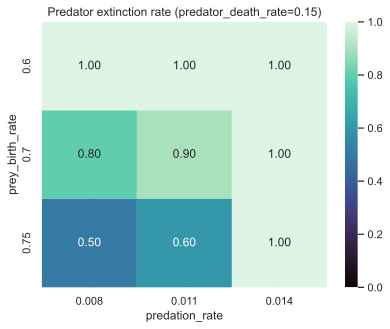

In [8]:
summary_df = pd.read_parquet(summary_path)

# Round parameter columns to avoid float precision noise in labels
param_cols = ["prey_birth_rate", "predation_rate", "predator_death_rate"]
summary_df[param_cols] = summary_df[param_cols].round(4)

# Example: visualize extinction risk as a heatmap (fix death rate to one slice)
death_rate = float(sorted(summary_df["predator_death_rate"].unique())[0])
slice_df = summary_df[summary_df["predator_death_rate"] == death_rate]
pivot = slice_df.pivot_table(
    index="prey_birth_rate",
    columns="predation_rate",
    values="predator_extinct_rate",
)

ax = sns.heatmap(pivot.sort_index(), annot=True, fmt=".2f", cmap="mako", vmin=0, vmax=1)
ax.set_title(f"Predator extinction rate (predator_death_rate={death_rate})")
ax.set_xlabel("predation_rate")
ax.set_ylabel("prey_birth_rate")
plt.show()

## 7) What's in the Database?

Consist stores provenance in DuckDB, which you can inspect directly. The key tables are:

| Table | Purpose |
|-------|---------|
| `run` | One row per execution: config hash, timestamps, status, parent linkage |
| `artifact` | File registry: paths (as portable URIs), content hashes, schemas |
| `run_artifact_link` | Many-to-many: which artifacts are inputs/outputs of which runs |
| `config_facet` | Deduplicated facet JSON blobs (content-addressed) |
| `run_config_kv` | Flattened key-value index for efficient facet filtering |

The `global_tables` schema contains **ingested artifact data** (our hot tier). Views like `v_sim_series` provide the hybrid interface.

### Portability

Because Consist stores:
- **Relative URIs** (not absolute paths)
- **Content hashes** (not just filenames)
- **Portable run metadata** (JSON snapshots in each run directory)

You can:
- Move the `runs/` directory to a different machine
- Share the `.duckdb` file with collaborators (after adjusting mount paths)
- Rebuild the database from JSON snapshots if it gets corrupted

> **Explore interactively**: DuckDB has a built-in UI. Run `duckdb -ui {path}` in your terminal to browse tables, run ad-hoc queries, and visualize the provenance graph.

In [9]:
from sqlalchemy import inspect
from sqlmodel import select

from consist.models import Artifact, ConfigFacet, Run, RunConfigKV

inspector = inspect(tracker.engine)

print("Database schema:")
print(f"  Main tables: {', '.join(inspector.get_table_names())}")
print(
    f"  Global tables: {', '.join(inspector.get_table_names(schema='global_tables'))}"
)
print(f"  Views: {', '.join(inspector.get_view_names())}")
print()

table_counts = {
    "run": run_query(select(func.count()).select_from(Run), tracker=tracker)[0],
    "artifact": run_query(select(func.count()).select_from(Artifact), tracker=tracker)[
        0
    ],
    "config_facet": run_query(
        select(func.count()).select_from(ConfigFacet), tracker=tracker
    )[0],
    "run_config_kv": run_query(
        select(func.count()).select_from(RunConfigKV), tracker=tracker
    )[0],
}

print("Row counts:")
for table, count in table_counts.items():
    print(f"  {table}: {count:,}")

print()
print(f"DuckDB file: {DB_PATH.relative_to(REPO_ROOT)}")
print(f"Open UI: duckdb -ui {DB_PATH.relative_to(REPO_ROOT)}")

Database schema:
  Main tables: sim_series, _dlt_loads, _dlt_pipeline_state, _dlt_version, artifact, artifact_schema, artifact_schema_field, artifact_schema_observation, artifact_schema_relation, config_facet, run, run_artifact_link, run_config_kv
  Global tables: sim_series, _dlt_loads, _dlt_pipeline_state, _dlt_version
  Views: consist_schema_links, v_sim_series

Row counts:
  run: 91
  artifact: 90
  config_facet: 90
  run_config_kv: 540

DuckDB file: examples/runs/predator_prey_demo/predator_prey_demo_demo.duckdb
Open UI: duckdb -ui examples/runs/predator_prey_demo/predator_prey_demo_demo.duckdb
